In [1]:
from IPython.display import HTML
from IPython.display import Image

### 数据处理

　　这次数据集我们会使用 [Movie Review data from Rotten Tomatoes](http://www.cs.cornell.edu/people/pabo/movie-review-data/)，这份数据集包含10662个样本，一半为积极，一半为消极的。数据集的词汇表大小为20k左右，因此，该数据集没有提供正式的训练集、测试集，所以我们简单的分割使用10%的数据集作为验证集。原论文中是使用10折交叉验证。数据处理过程:
- 从原始数据集中载入积极和消极的句子；
- 使用与原论文的[代码](https://github.com/yoonkim/CNN_sentence)清洗文本数据；
- 将每个句子填充到最大句子的长度59，在其它句子送使用特殊的 < pad >进行填充，使其句子长度达到59。将句子填充到相同的长度是非常有用的，这样能使用批处理mini-batch，因批处理需要有相同的长度；
- 建立词汇表的索引，并对每个词进行one-hot编码（即映射到0到18765间，词汇表的大小）。每个句子成为一个整数的向量。

### 模型构建

　　构建的网络架构如下图：

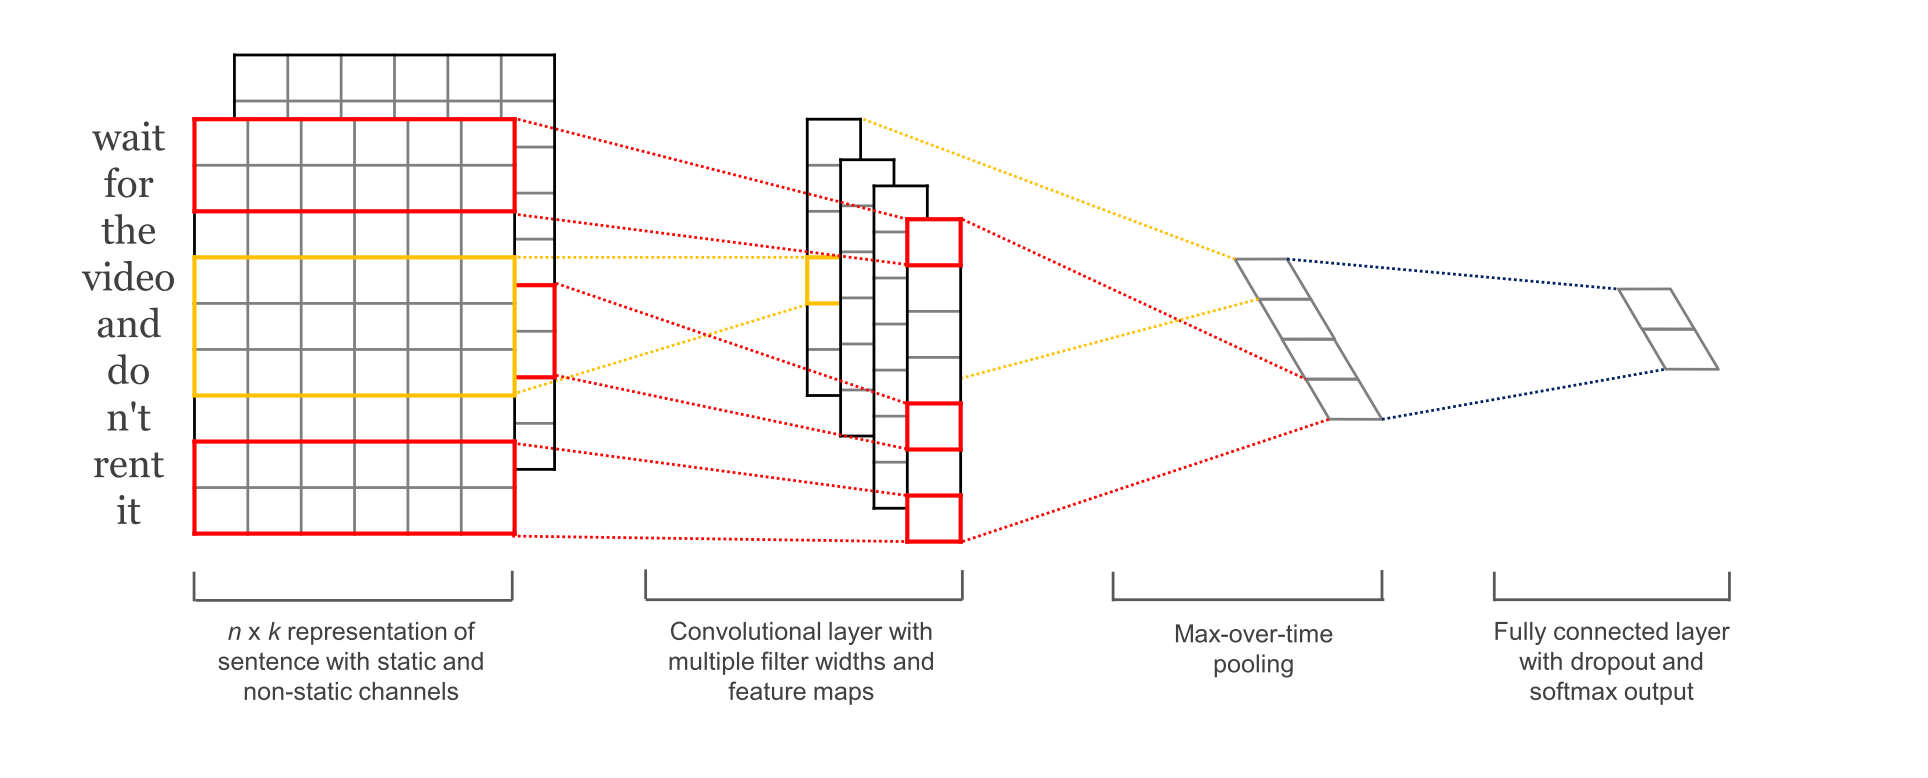

In [3]:
Image('http://www.wildml.com/wp-content/uploads/2015/11/\
Screen-Shot-2015-11-06-at-8.03.47-AM.png')

　　第一层将单词嵌入到低维向量，下一层使用多个卷积核对嵌入的单词向量进行卷积操作。举例，可使用宽度为输入层的宽度，高度为3、4或5个单词的多个卷积核。接下来，将卷积层的结果进行最大池化操作为特征向量，添加dropout的正则项，使用softmax层进行分类。因为这是一篇指导文章，所以对原论文的模型进行简化：
- 不为词使用预训练的word2vec向量，相反会重新开始学习嵌入；
- 不对权重向量进行L2范数的约束，[ A Sensitivity Analysis of (and Practitioners’ Guide to) Convolutional Neural Networks for Sentence Classification](https://arxiv.org/abs/1510.03820)该篇文章表明权重的约束对最终结果影响不大；
- 原文对输入数据使用了两个通道（channels），静态的和动态的词向量，这里只使用一个通道。

### 实现模型

　　为了各种超参数的设置，我们将代码放到TextCNN类中，在init函数中生成模型图。

In [9]:
import tensorflow as tf
import numpy as np

class TextCNN(object):
    '''
    用于文本分类的CNN，使用嵌入层，接卷积层和最大词化层。
    '''
    def __init__(self, sequence_length, num_classes, vocab_size, embedding_size, 
                             filter_sizes, num_filters):
        pass

　　为了实例化这个类，我们传入以下参数：
- sequence_length，句子的长度。记得我们将所有句子填充，使其长度相同（对此份数据集长度为59）；
- num_classes，输出层的类别数，二分类为积极或消极；
- vocab_size，词汇表的大小。需要定义嵌入层的大小，即[vocabulary_size, embedding_size];
- embedding_size，嵌入层的维度；
- filter_sizes，希望卷积层覆盖的单词数，这里指定卷积核的数目。比如[3, 4, 5]表示三种不同的卷积核将扫过3、4和5个单词，总的卷积核数目等于三种不同的卷积核乘以卷积核的数目；
- num_filters ，卷积核数目；

#### input placeholders
　　首先定义传递给网络的输入数据，定义输入、输出和dropout的placeholders

self.input_x = tf.placeholder(tf.int32, [None, sequence_length], name='input_x')
self.input_y = tf.placeholder(tf.float32, [None, num_classes], name='input_y')
self.dropout_keep_prob = tf.placeholder(tf.float32, name='dropout_keep_prob')

　　tf.placeholder创建了一个placeholder的变量，当在训练或测试时，在赋具体的值。第二个参数是张量的维度大小。None表示该维度的长度可以是任何长度。在我们的例子中，第一个维度是batch size，使用None可以让网络处理任意大小的批次。<br />
　　在dropout中保留神经元的概率也是网络的输入，因为要确保dropout只用于网络训练期间，而在验证模型时，则要关闭dropout。

#### input placeholders
　　定义的第一层为嵌入层，它将词汇表的词映射到低维向量表示。它本质上是一个我们从数据中学习到的查找表格，即该词对应的低维向量表中的表示。

In [ ]:
with tf.device('/cpu:0') , tf.name_scope('embedding'):
    W = tf.Variable(tf.random_uniform([vocab_size, embedding_size], -1.0, 1.0), name='W')
    self.embedded_chars = tf.nn.embedding_lookup(W, self.input_X)
    self.embedded_chars_expanded = tf.expand_dims(self.embedded_chars, -1)

- tf.device('/cpu:0')表示将在第一个cpu上执行训练模型操作。默认情况下，TensorFlow会尝试在GPU上（如果有）执行操作；
- tf.name_scope创建一个名为"embedding"的Name Scope，这个scope将所有操作添加到名为"embedding"的顶部节点中，以便在TensorFlow中可视化网络时获得更好的层次结构。

　　W是我们在训练过程中学习到的嵌入矩阵，使用随机分布对其进行初始化。tf.nn.embedding_lookup创建一个实际的嵌入操作，嵌入操作的结果是一个三维张量表示，其维度大小为[None, sequence_length, embedding_size]。<br />
　　TensorFlow的卷积conv2d操作需要的维度为batch、width、height和channel的四维张量，即批处理大小，卷积核宽度、卷积核高度、卷积核通道数。这里嵌入的结果不包含通道维度，所以手动添加它，于是维度为[None, sequence_length, embedding_size, 1]，卷积核宽度为一次扫过句子序列sequence_length的多个词，高度为低维矩阵的全部宽度。

#### Convolution and Max-Pooling Layers

　　现在准备构建卷积层和最大池化层，记得要使用不同尺寸的卷积核（不同的卷积核类似于n-gram，比如使用卷积核高度为2的，即扫过两个词，类似2-gram；使用卷积核高度为3的，即扫过三个词，类似于3-gram）。因此不同的卷积核会产生不同尺寸的张量，产生不同的卷积层，将结果合并为一个大的特征向量。

In [ ]:
pooled_outputs = []
for i, filter_size in enumerate(filter_sizes):
    with tf.name_scope('conv_maxpool-%s' % filter_size):
        # 卷积层
        filter_shape = [filter_size, embedding_size, 1, num_filters]
        W = tf.Variable(tf.truncated_normal(filter_shape, stddev=0.1), name='W')
        b = tf.Variable(tf.constant(0.1, shape=[num_filters]), name='b')
        conv = tf.nn.conv2d( self.embedded_chars_expanded, 
                                          W, 
                                          strides=[1, 1, 1, 1],
                                          padding='VALID',
                                          name='conv')
        # relu激活函数
        h = tf.nn.relu(tf.nn.bias_add(conv, b), name='relu')
        # 最大池化层
        pooled = tf.nn.max_pool(h,
                                                 ksize=[1, sequence_length - filter_size+1, 1, 1],
                                                 strides=[1, 1, 1, 1],
                                                 padding='VALID',
                                                 name='pool')
        pooled_outputs.append(pooled)
# 结合所有的池化特征
num_filters_total = num_filters * len(filter_sizes)
self.h_pool = tf.concat(3, pooled_outputs)
self.h_pool_flat = tf.reshape(self.h_pool, [-1, num_filters_total])

　　这里，W为卷积核矩阵，h是将非线性激活函数运用于卷积输出的结果。每个卷积核的宽度都是相同的，即等于嵌入维数，高度为一次扫过多少个词。"VALID"填充表示我们直接使用卷积核扫描句子，不对边缘进行填充。执行一个narrow convolution（不使用padding），获得输出的维度[1, sequence_length - filter_size + 1, 1, 1]，接着在执行最大池化操作获得张量维度为[batch_size, 1, 1, num_filters]。这实质上是一个特征向量，最后一个维度对应于特征（卷积核数目，不同卷积核抽取不同特征信息）。一旦我们从每个卷积核中获得所有的池化输出张量，将其合并为一个维度大小为[batch_size, num_filters_total]的长特征向量。在TensorFlow的tf.reshape中，使用-1表示对该维度进行展开操作。<br />

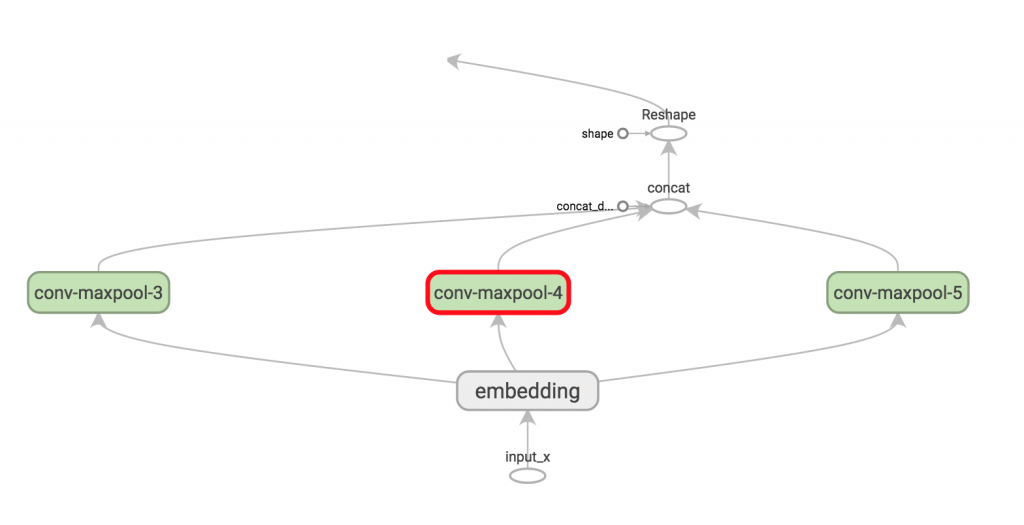

In [2]:
Image('http://www.wildml.com/wp-content/uploads/2015/12/\
Screen-Shot-2015-12-10-at-10.13.50-AM1-1024x525.png')

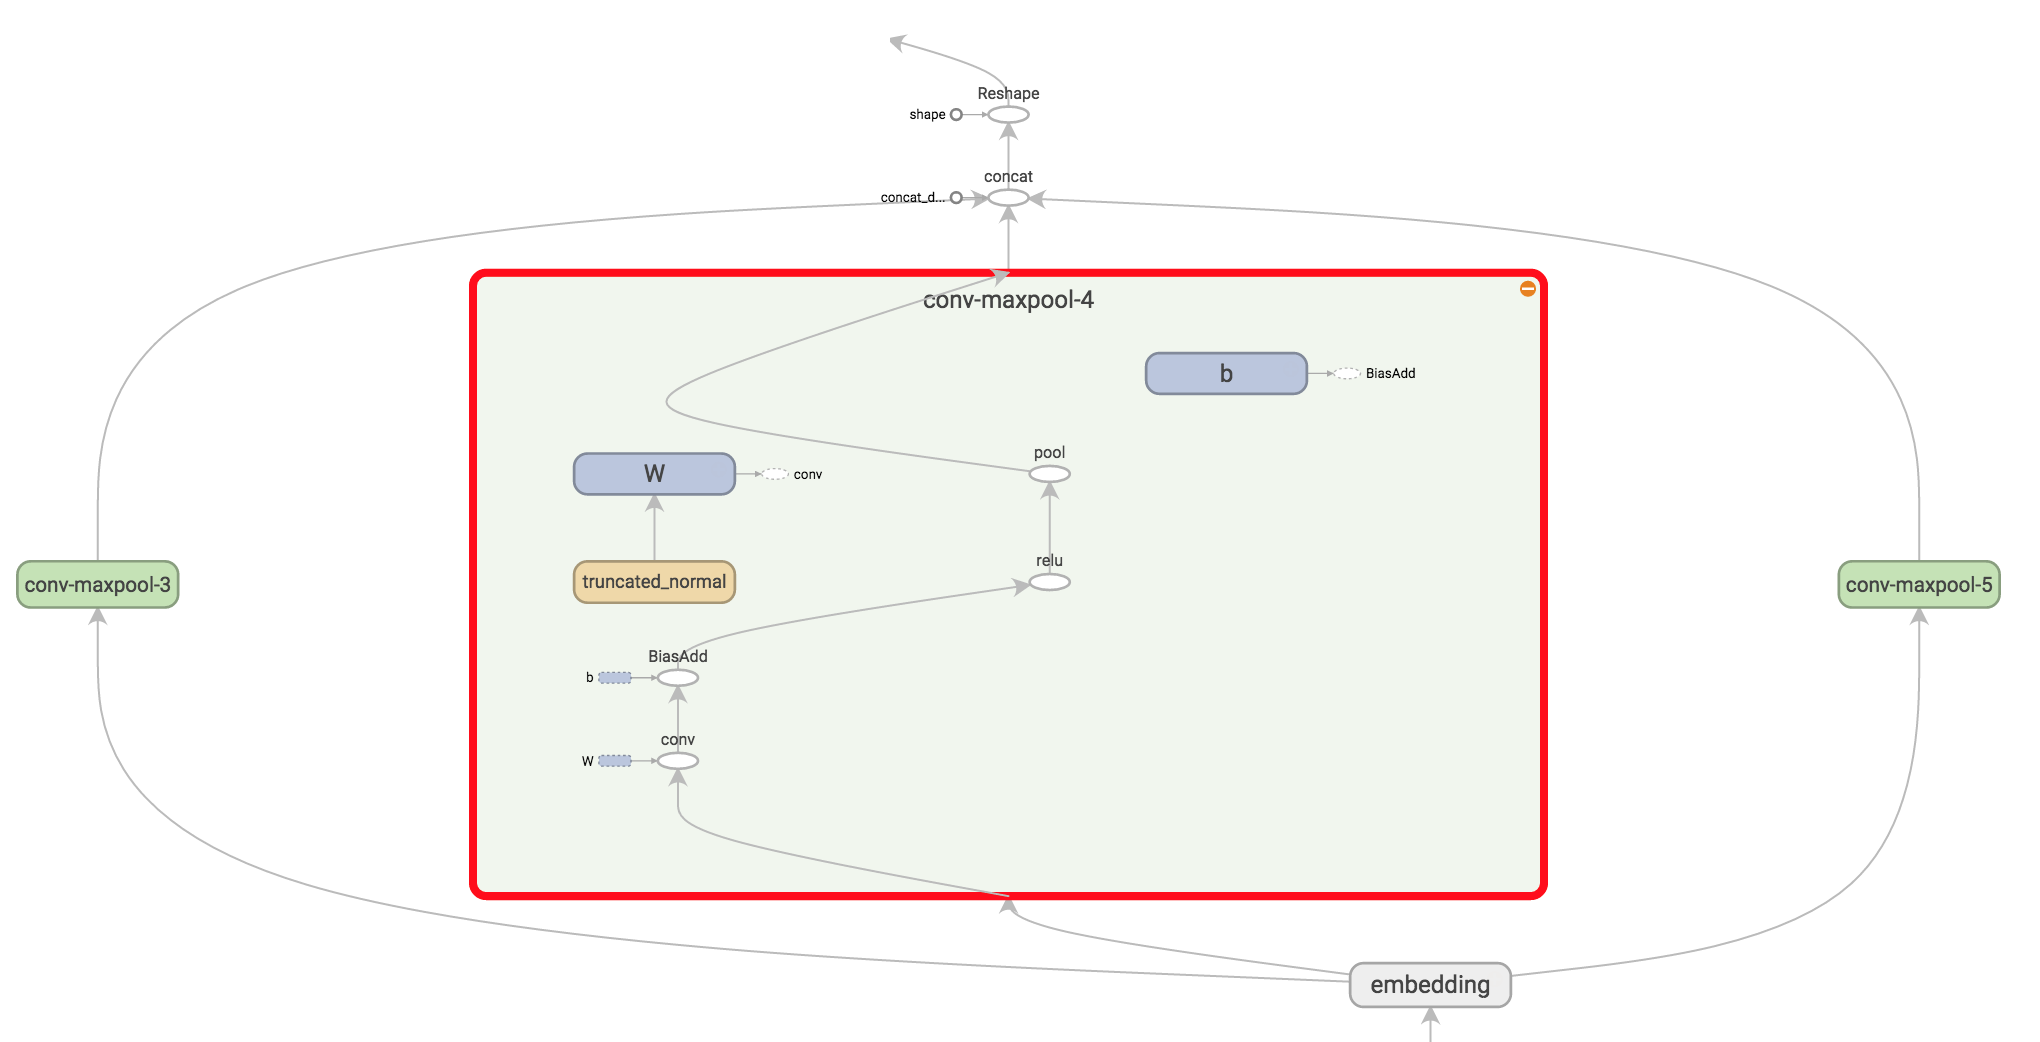

In [3]:
Image('http://www.wildml.com/wp-content/uploads/\
2015/12/Screen-Shot-2015-12-10-at-10.22.29-AM.png')

#### Dropout Layer
　　Dropout是卷积神经网络正则化最常使用的方法。dropout背后的思想非常简单，一个dropout层会随机禁用其一部分神经元，强迫剩下的神经元学习有用的特征。dropout保留神经元的概率由参数dropout_keep_prob决定。在训练期间，将dropout_keep_prob设为0.5，而在验证模型中，则将dropout_keep_prob设为1。

In [ ]:
# 添加dropout层
with tf.name_scope('dropout'):
    self.h_drop = tf.nn.dropout(self.h_pool_flat, self.dropout_keep_prob)

#### Scores and Predictions
　　从最大池化层中使用特征向量，通过矩阵乘法得到预测值，选择最高得分作为预测的类。或是使用softmax函数将原始分数转换为标准化概率，选择最大概率值。

In [ ]:
with tf.name_scope('output'):
    W = tf.Variable(tf.truncated_normal([num_filters_total, 
                                         num_classes], stddev=0.1), name='W')
    b = tf.Variable(tf.constant(0.1, shape=[num_classes]), name='b')
    self.scores = tf.nn.xw_plus_b(self.h_drop, W, b, name='scores')
    self.predictions = tf.argmax(self.scores, 1, name='predictions')

　　这里，tf.nn.xw_plus_b是表示矩阵乘法 $Wx+b$ 的一种简便方法。

#### Loss and Accuracy
　　损失函数用于衡量网络的误差，我们的目标是最小化损失函数，分类问题的标准损失函数为交叉熵损失。

In [ ]:
# 计算交叉熵损失的均值
with tf.name_scope('loss'):
    losses = tf.nn.softmax_cross_entropy_with_logits(self.scores, self.input_y)
    self.loss = tf.reduce_mean(losses)

　　tf.nn.softmax_cross_entropy_with_logits用于计算每个类的交叉熵，需要给定分数值和正确的输出标签值，在求均值。也可以求和，但难以比较不同批次大小的损失和训练集、验证集的损失，因求和会受数据集的维度大小影响。
　　我们也定义了准确率的表达式，即预测类等于输出类标签的有多少。

In [ ]:
# 计算准确率
with tf.name_scope('accuracy'):
    correct_predictions = tf.equal(self.predictions, tf.argmax(self.input_y, 1))
    self.accuracy = tf.reduce_mean(tf.cast(correct_predictions, 'float'), name='accuracy')

#### Visualizing the network
　　

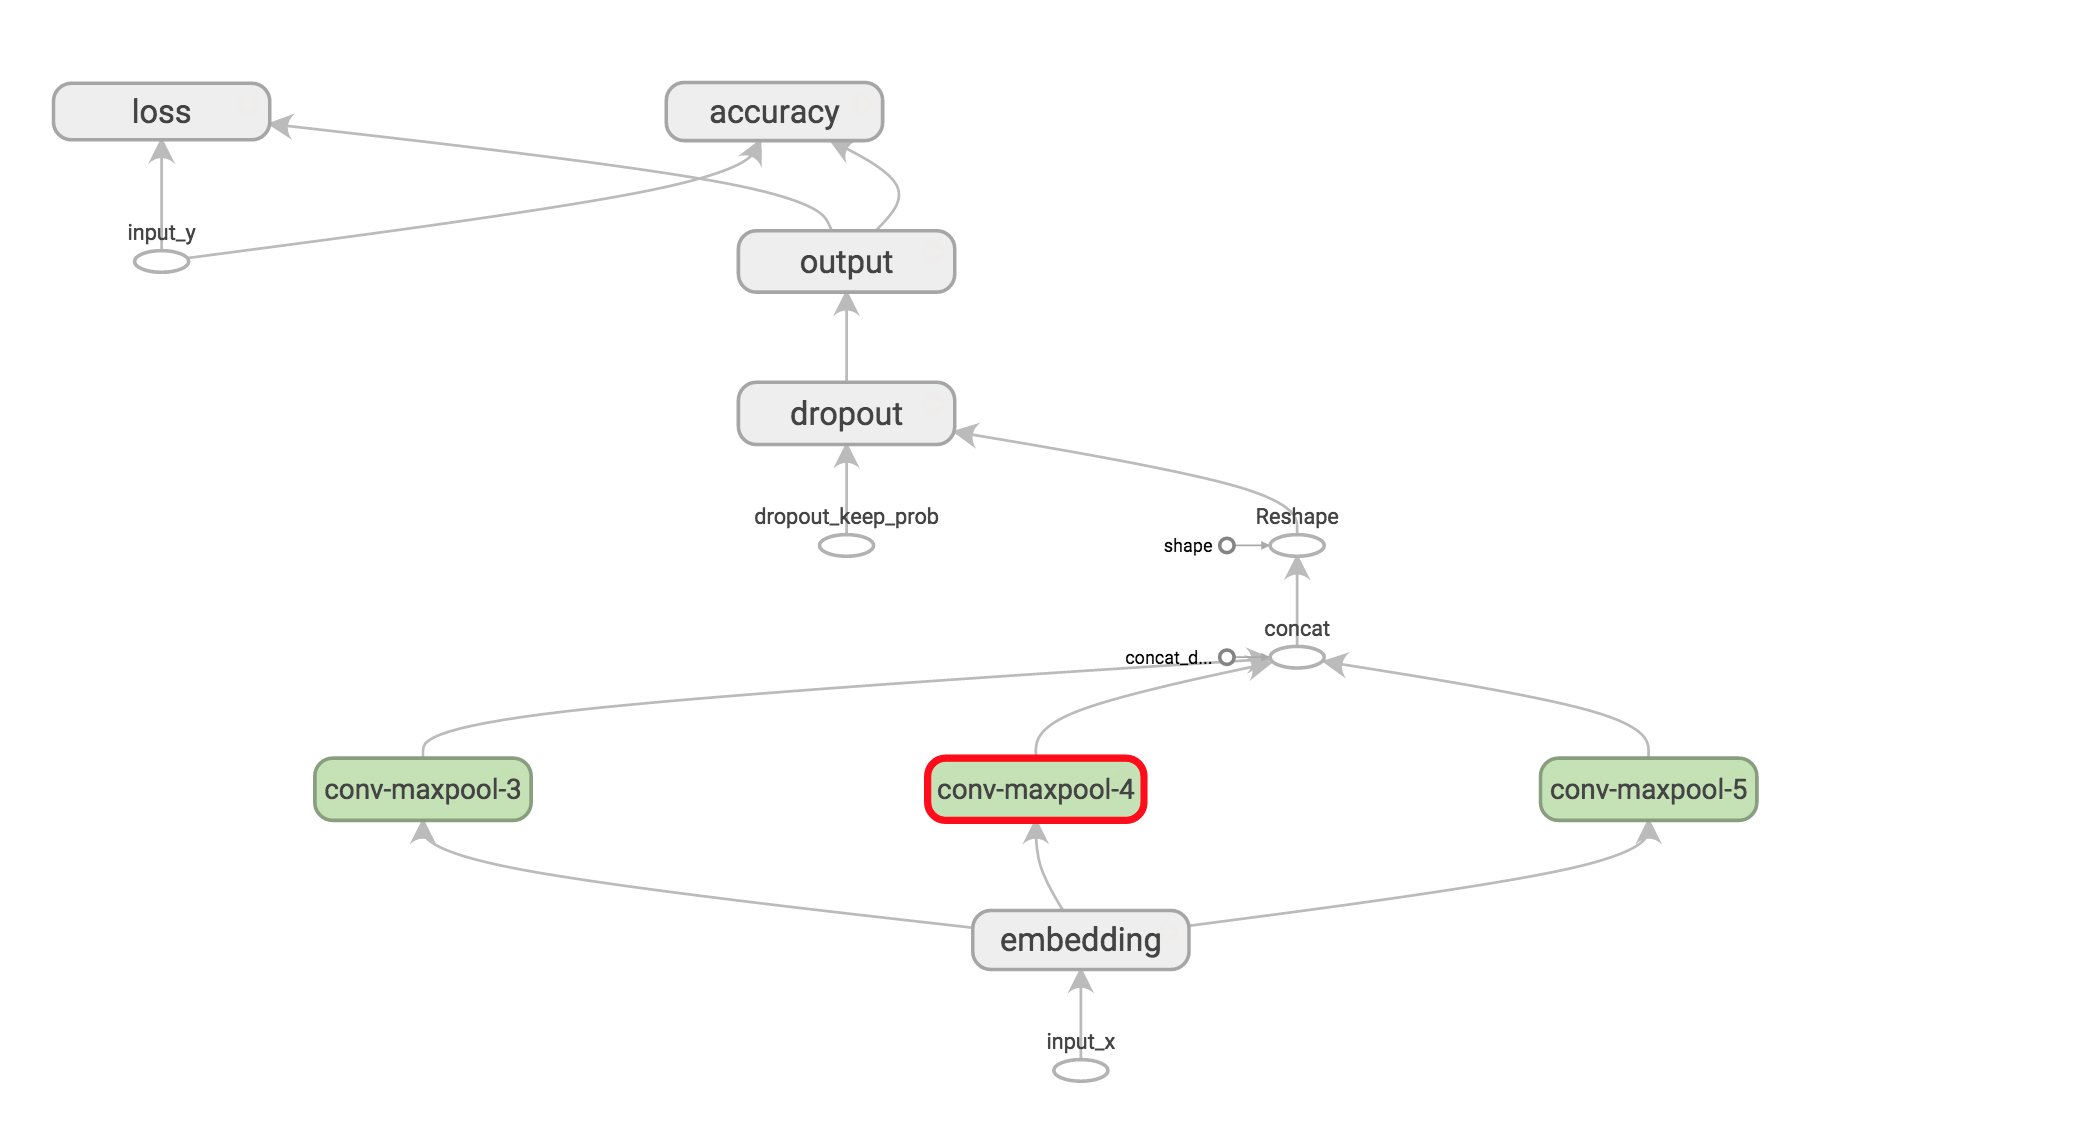

In [4]:
Image('http://www.wildml.com/wp-content/uploads\
/2015/12/Screen-Shot-2015-12-10-at-10.25.46-AM.png')

#### Training Procedure

　　在我们为网络定义训练程序之前，需要了解一些基本知识关于TensorFlow是如何使用Sessions和Graphs。<br />
　　在TensorFlow中，一个Session是你要执行graph操作的环境，包含Variables和queues的状态。每个session都在一个graph上进行。当你在创建variables和operations没明确使用session，你可以使用TensorFlow创建默认的session。你可以通过在session.as_default()执行命令来更改默认的session。

　　一个Graph包含operations和tensors（张量）。在程序中你可以使用多个graphs，但多数情况下你只需要一个graph。也可以在多个sessions使用相同的graph，但不能在一个session使用多个graphs。TensorFlow总会创建默认的graph，但你也可以手动创建一个graph，并设置为新的默认，例如下面的例子。手动创建sessions和graphs可确保当你不再需要资源时，可正确释放资源。

In [ ]:
with tf.Graph().as_default():
    session_conf = tf.ConfigProto(
                    allow_sotf_placement=FLAGS.allow_soft_placement,
                    log_device_placement=FLAGS.log_device_placement)
    sess = tf.Session(config=session_conf)
    with sess.as_default():
        # Code that operates on the default graph and session comes here...

In [ ]:
allow_soft_placement